# IBM Applied Data Science Capstone Final Project
### Battle of the Neighborhood: Which neighborhood will fit your retirement life?

## Introduction

San Diego is known to be one of the best place for people to retire in. Which eighborhood will you choose in the city? Each retiree-to-be will have very different opinion. Does he prefer to live close to a park, close to public transportation, or close to restaurants? In this project I will work on the data from all neighborhoods in the city and recommend the ones based on people's preference. Not all factors are considered to make the final decision in this project, but this is a good start to know the city. Later on we can add more creteria to improve the model. In this project, I will:

- Build a dataframe of neighborhoods in San Diego, CA by web scraping Wikipedia data
- Retrieve the geographical coordinates for the neighborhoods
- From Foursquare API, retrieve the surrounding venue data
- Explore and fine tune the venue categories
- Clustering the neighboorhood and use Folium to show them on the map
- And recommend neighborhood from people's personal preference

And now, let's get started.


## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Download Neighborhood Data from Wikipedia</a>

2. <a href="#item2">Explore Neighborhoods in New York City</a>

3. <a href="#item3">Analyze Each Neighborhood</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    
    
6. <a href="#item6">Recommendation</a>  
</font>
</div>

Let's download all the libraries that we will need.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

#!conda install -c conda-forge geocoder --yes
!pip install geocoder
import geocoder

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# import bs4 for web scraping
from bs4 import BeautifulSoup
import lxml

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 102kB 5.4MB/s ta 0:00:011
Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    folium-0.5.0               |             py_0          45 KB  conda-forge
    branca-0.3.1               |             py_0          25 KB  conda-forge
    ca-certificates-2019.11.28 |       hecc5488_0         145 KB  conda-forge
    altair-4.0.1               |             py_0         575 KB  conda-forge
    openssl-1.1.1d             |       h516909a_0         2.1 MB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    ------------------------------------------------------------
                                   

<a id='item1'></a>
## 1. Download Neighborhood Data from Wikipedia

In [3]:
wikiurl="https://en.wikipedia.org/wiki/List_of_communities_and_neighborhoods_of_San_Diego"
page=requests.get(wikiurl)
soup=BeautifulSoup(page.text,'lxml')

In [4]:
neighborhood_list=[]
for cell in soup.find('tbody').findAll("li"):
    if len(cell.findAll("li"))>0:
        for subcell in cell.findAll("li"):
            neighborhood_list.append(subcell.text)
            #print('subcell ', subcell.text)
    else:
        neighborhood_list.append(cell.text)
        #print('cell ', cell.text)
neighborhood_list=list(set(neighborhood_list))
sd_df=pd.DataFrame({'Neighborhoods':neighborhood_list})
sd_df.head()

,Neighborhoods
0,Ocean View Hills
1,North Park
2,La Playa
3,Sunset Cliffs
4,Little Italy


### Get the latitude and longitude values of each neighborhood

In [5]:
address = 'San Diego, CA'

geolocator = Nominatim(user_agent="SD_explorer")
location = geolocator.geocode(address)
sd_latitude = location.latitude
sd_longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format(address,sd_latitude, sd_longitude))
print(location)

The geograpical coordinate of San Diego, CA are 32.7174209, -117.1627714.
San Diego, San Diego County, California, United States of America


In [41]:
# it turns out that geolocator.geocode returns few neighborhood with None. Try geocoder.arcgis
"""
def get_coord(address):
    geolocator = Nominatim(user_agent="SD_explorer")
    location = None
    n=0
    while(location is None and n<10):
        location = geolocator.geocode('{}, San Diego, CA'.format(address))
        print(address, n, location)
        n=n+1
    if (location is None):
        latitude = None
        longitude = None
    else:
        latitude = location.latitude
        longitude = location.longitude

    return latitude, longitude
"""

In [13]:
#!conda install -c conda-forge geocoder --yes
#import geocoder

In [8]:
def get_latlng(neighborhood):
    # initialize your variable to None
    lat_lng_coords = None
    n=0
    # loop until you get the coordinates
    while(lat_lng_coords is None and n<5):
        g = geocoder.arcgis('{}, San Diego, CA'.format(neighborhood))
        lat_lng_coords = g.latlng
        n=n+1
    print(neighborhood, lat_lng_coords)
    return lat_lng_coords

In [9]:
geo = [get_latlng(neigh) for neigh in sd_df["Neighborhoods"].tolist()]

Ocean View Hills [32.56869605663482, -117.01410082440756]
North Park [32.74526000000003, -117.13234999999997]
La Playa [32.718300000000056, -117.23369999999994]
Sunset Cliffs [32.728500000000054, -117.25001999999995]
Little Italy [32.72586000000007, -117.1676]
Serra Mesa [32.79598000000004, -117.12493999999998]
Rancho Encantada [32.92718000000008, -117.01959999999997]
Uptown [32.74900373483304, -117.15460506551206]
Morena [32.769490000000076, -117.19006999999999]
Pacific Beach [32.801390000000026, -117.24135999999999]
Harborview [32.72715000000005, -117.17259999999999]
Del Mar Mesa [32.942570000000046, -117.18641999999994]
Chollas View [32.715050000000076, -117.09319999999997]
Horton Plaza [32.71565000000004, -117.16516999999999]
Lake Murray [32.808620000000076, -117.02034999999995]
Harbor Island [32.72522967803902, -117.20170962471273]
South Park [32.72729000000004, -117.12960999999996]
Memorial [32.69598000000008, -117.12562999999994]
La Jolla Village [32.86162000000007, -117.2332199

In [10]:
coord_df = pd.DataFrame(geo, columns=['Latitude', 'Longitude'])
sd_df['Latitude']=coord_df['Latitude']
sd_df['Longitude']=coord_df['Longitude']

In [11]:
sd_df.head()

,Neighborhoods,Latitude,Longitude
0,Ocean View Hills,32.568696,-117.014101
1,North Park,32.745260,-117.132350
2,La Playa,32.718300,-117.233700
3,Sunset Cliffs,32.728500,-117.250020
4,Little Italy,32.725860,-117.167600


In [12]:
sd_df.to_csv("sd_neighbor.csv", index=False)
#sd_df=pd.read_csv("sd_neighbor.csv")
#sd_df.head()

### Create a map of San Diego with neighborhoods superimposed on top.

In [14]:
# create map of San Diego using latitude and longitude values
map_sd = folium.Map(location=[sd_latitude, sd_longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(sd_df['Latitude'], sd_df['Longitude'], sd_df['Neighborhoods']):
    label = neighborhood
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sd)  
    
map_sd

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.
#### Define Foursquare Credentials and Version

In [15]:
# The code was removed by Watson Studio for sharing.

Your credentails:
CLIENT_ID: XK5K2CXTI4HJJ2QNKBEC1KAEY0APFVTDR4WQ4SFOISFZO15C
CLIENT_SECRET:SFAXTXQ3H5VSLCY1LI34DF3KNAYBCLB1VBWZVNITDFCGHLAI


#### Let's explore the first neighborhood in our dataframe.

In [16]:
sd_df.loc[0, 'Neighborhoods']

'Ocean View Hills'

In [17]:
neighborhood_latitude = sd_df.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = sd_df.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = sd_df.loc[0, 'Neighborhoods'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Ocean View Hills are 32.56869605663482, -117.01410082440756.


#### Now, let's get the top 100 venues that are within a radius of 500 meters.

First, let's create the GET request URL.

In [18]:
# type your answer here
radius=500
LIMIT=100

# construct URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
#url # display URL


In [19]:
results = requests.get(url).json()
#results

In [20]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [21]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Adrian's Lobster Fiesta,Seafood Restaurant,32.569861,-117.012139
1,Greenfield Village Gym,Gym,32.569861,-117.012139
2,Greenfield Village Pool Side,Pool,32.569651,-117.011573
3,CA-905 & Caliente Ave / Ocean View Hills Pkwy,Intersection,32.566300,-117.014370


<a id='item2'></a>
## 2. Explore Neighborhoods in San Diego

#### Create a function to repeat the same process to all the neighborhoods

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhoods', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *sd_venues*.

In [23]:
sd_venues = getNearbyVenues(names=sd_df['Neighborhoods'],
                                   latitudes=sd_df['Latitude'],
                                   longitudes=sd_df['Longitude']
                                  )

Ocean View Hills
North Park
La Playa
Sunset Cliffs
Little Italy
Serra Mesa
Rancho Encantada
Uptown
Morena
Pacific Beach
Harborview
Del Mar Mesa
Chollas View
Horton Plaza
Lake Murray
Harbor Island
South Park
Memorial
La Jolla Village
Shelter Island
Webster
Midtown
Nestor
Skyline
Encanto
Mira Mesa
San Ysidro
Marston Hills
Grant Hill
Barrio Logan
Logan Heights
Mission Beach
Carmel Mountain Ranch
Emerald Hills
Bay Park
Tierrasanta
Bay Ho
Roseville-Fleetridge
Columbia
Palm City
Valencia Park
Kearny Mesa
Egger Highlands
Hillcrest
Sorrento Valley
Redwood Village
Point Loma Heights
College Area
Core
Carmel Valley
Border
Jamacha
East Village
Black Mountain Ranch
East Elliott
University Heights
Bankers Hill
Del Mar Heights
El Cerrito
Alta Vista
Torrey Hills
Mountain View
San Carlos
Bay Terraces
Allied Gardens
Shelltown
Southcrest
Stockton
Civita
Midway
City Heights
Gateway
Clairemont
Ocean Crest
Talmadge
Torrey Highlands
Sorrento Mesa
Village of La Jolla
Torrey Pines
Mt. Hope
Rolando Park
Burlin

In [24]:
print(sd_venues.shape)
sd_venues.head()

(2207, 7)


,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Ocean View Hills,32.568696,-117.014101,Adrian's Lobster Fiesta,32.569861,-117.012139,Seafood Restaurant
1,Ocean View Hills,32.568696,-117.014101,Greenfield Village Gym,32.569861,-117.012139,Gym
2,Ocean View Hills,32.568696,-117.014101,Greenfield Village Pool Side,32.569651,-117.011573,Pool
3,Ocean View Hills,32.568696,-117.014101,CA-905 & Caliente Ave / Ocean View Hills Pkwy,32.566300,-117.014370,Intersection
4,North Park,32.745260,-117.132350,Subterranean Coffee Boutique,32.746656,-117.130256,Coffee Shop


In [25]:
sd_venues.groupby('Neighborhoods').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhoods,,,,,,
Allied Gardens,16,16,16,16,16,16
Alta Vista,3,3,3,3,3,3
Balboa Park,37,37,37,37,37,37
Bankers Hill,35,35,35,35,35,35
Barrio Logan,26,26,26,26,26,26
Bay Ho,5,5,5,5,5,5
Bay Park,4,4,4,4,4,4
Bay Terraces,2,2,2,2,2,2
Birdland,5,5,5,5,5,5


In [30]:
sd_venues[sd_venues["Venue Category"]=="Neighborhood"]

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1049,Little Italy,32.725860,-117.167600,Little Italy,32.723660,-117.168405,Neighborhood
1456,Columbia,32.722298,-117.167409,Little Italy,32.723660,-117.168405,Neighborhood
1632,Uptown,32.749004,-117.154605,GLBT Rainbow Pride Flag-Hillcrest,32.748711,-117.149663,Neighborhood


In [26]:
sd_venues.to_csv("sd_venues.csv", index=False)

Next, I will consolidate the Venue Category. It turns out that many of the categories are similar with slightly different naming. For example, the 'bar' category can also be recorded as "Cocktail Bar", "Whisky Bar", "Tiki Bar", "Sports Bar", "Wine Bar", "Bar", "Beer Bar", etc. I will update the "Venue Category" column to use as less naming as possible, by combining the similar categories into one.

In [27]:
cat_final=[]
fast_list=["Deli / Bodega","Smoothie Shop","Sandwich Place","Snack Place","Cupcake Shop","Street Food Gathering","College Cafeteria"\
           "Bubble Tea Shop","Food & Drink Shop","Food","Coffee Shop","Pizza Place","Burrito Place","Donut Shop","Dessert Shop",\
           "Noodle House","Bakery","Food Court","Tea Room","Café","Pie Shop","Burger Joint","Frozen Yogurt Shop","Hot Dog Joint",\
           "BBQ Joint","Food Truck","Fried Chicken Joint","Wings Joint","Poke Place","Taco Place"]
market_list=["Farmers Market","Supermarket","Duty-free Shop","Flea Market","Organic Grocery","Grocery Store","Market","Arts & Crafts Store"]
museum_list=["Museum","Art Museum","Science Museum","Historic Site","History Museum","Monument / Landmark"]
parkrec_list=["Trail","Beach","Mountain","State / Provincial Park","Harbor / Marina","Theme Park","Nature Preserve","Skate Park",\
             "Outdoors & Recreation","Baseball Field","Skating Rink","Fishing Spot","Pool","Park","Scenic Lookout",\
             "Theme Park Ride / Attraction","Playground"]
restaurant_list=["Diner","Steakhouse","Irish Pub","Breakfast Spot","Buffet","Gourmet Shop"]
salon_list=["Nail Salon","Tanning Salon","Salon / Barbershop"]
sport_list=["Tennis Court","Golf Course","Track","Athletics & Sports","Basketball Court","Gym","Baseball Stadium","Surf Spot",\
            "Gym / Fitness Center","Soccer Field"]
theater_list=["Theater","Drive-in Theater","Movie Theater","Amphitheater","Performing Arts Venue","Concert Hall"]
transit_list=["Travel & Transport","Bus Station","Light Rail Station","Tram Station","Train Station","Bus Stop"]

for cat in sd_venues['Venue Category']:
    new=cat
    if "Bar" in cat:
        new="Bar"
    elif new in fast_list:
        new="Fast Food"
    elif new in market_list:
        new="Market"
    elif new in museum_list:
        new="Museum"
    elif new in parkrec_list:
        new="ParkRec"
    elif (new in restaurant_list) or ("Restaurant" in cat):
        new="Restaurant"
    elif new in salon_list:
        new="Salon"
    elif new in sport_list:
        new="Sport"    
    elif new in theater_list:
        new="Theater"  
    elif new in transit_list:
        new="Transit"
    cat_final.append(new)


In [28]:
sd_venues['New Category']=cat_final
sd_venues.to_csv("sd_new_venues.csv", index=False)

In [29]:
sd_venues.head()

,Neighborhoods,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,New Category
0,Ocean View Hills,32.568696,-117.014101,Adrian's Lobster Fiesta,32.569861,-117.012139,Seafood Restaurant,Restaurant
1,Ocean View Hills,32.568696,-117.014101,Greenfield Village Gym,32.569861,-117.012139,Gym,Sport
2,Ocean View Hills,32.568696,-117.014101,Greenfield Village Pool Side,32.569651,-117.011573,Pool,ParkRec
3,Ocean View Hills,32.568696,-117.014101,CA-905 & Caliente Ave / Ocean View Hills Pkwy,32.566300,-117.014370,Intersection,Intersection
4,North Park,32.745260,-117.132350,Subterranean Coffee Boutique,32.746656,-117.130256,Coffee Shop,Fast Food


In [30]:
print('There are {} uniques categories.'.format(len(sd_venues['New Category'].unique())))

There are 157 uniques categories.


<a id='item3'></a>
## 3. Analyze Each Neighborhood

In [31]:
# one hot encoding
sd_onehot = pd.get_dummies(sd_venues[['New Category']], prefix="", prefix_sep="")
#sd_onehot = pd.get_dummies(sd_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
sd_onehot['Neighborhoods'] = sd_venues['Neighborhoods'] 

# move neighborhood column to the first column
fixed_columns = [sd_onehot.columns[-1]] + list(sd_onehot.columns[:-1])
sd_onehot = sd_onehot[fixed_columns]

sd_onehot.head()

,Neighborhoods,ATM,Accessories Store,Antique Shop,Arcade,Art Gallery,Astrologer,Auto Workshop,Automotive Shop,Bagel Shop,Bank,Bar,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Building,Business Service,Butcher,Camera Store,Candy Store,Casino,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Club House,College Cafeteria,Comedy Club,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cruise,Currency Exchange,Dance Studio,Department Store,Discount Store,Doctor's Office,Dog Run,Electronics Store,Entertainment Service,Event Service,Event Space,Eye Doctor,Fast Food,Flower Shop,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gun Range,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hostel,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indoor Play Area,Insurance Office,Intersection,Island,Jewelry Store,Kids Store,Laundromat,Laundry Service,Leather Goods Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Men's Store,Military Base,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Optical Shop,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,ParkRec,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Plaza,Pop-Up Shop,Pub,Public Bathroom,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon,Sculpture Garden,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Speakeasy,Sport,Sporting Goods Shop,Stables,Storage Facility,Supplement Shop,Tattoo Parlor,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Transit,Vape Store,Video Game Store,Video Store,Wine Shop,Women's Store,Yoga Studio
0,Ocean View Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Ocean View Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Ocean View Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Ocean View Hills,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,North Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [32]:
sd_onehot.shape

(2207, 158)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [33]:
sd_grouped = sd_onehot.groupby('Neighborhoods').mean().reset_index()
sd_grouped

,Neighborhoods,ATM,Accessories Store,Antique Shop,Arcade,Art Gallery,Astrologer,Auto Workshop,Automotive Shop,Bagel Shop,Bank,Bar,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Building,Business Service,Butcher,Camera Store,Candy Store,Casino,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Club House,College Cafeteria,Comedy Club,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cruise,Currency Exchange,Dance Studio,Department Store,Discount Store,Doctor's Office,Dog Run,Electronics Store,Entertainment Service,Event Service,Event Space,Eye Doctor,Fast Food,Flower Shop,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gun Range,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hostel,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indoor Play Area,Insurance Office,Intersection,Island,Jewelry Store,Kids Store,Laundromat,Laundry Service,Leather Goods Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Men's Store,Military Base,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Optical Shop,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,ParkRec,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Plaza,Pop-Up Shop,Pub,Public Bathroom,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon,Sculpture Garden,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Speakeasy,Sport,Sporting Goods Shop,Stables,Storage Facility,Supplement Shop,Tattoo Parlor,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Transit,Vape Store,Video Game Store,Video Store,Wine Shop,Women's Store,Yoga Studio
0,Allied Gardens,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.312500,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.062500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.062500,0.000000,0.000000,0.000000
1,Alta Vista,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,0.000000

#### Let's confirm the new size

In [34]:
sd_grouped.shape

(111, 158)

#### Let's get top 10 most common venues for each neighborhood, and save it to a DataFrame
First, let's write a function to sort the venues in descending order.

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhoods']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhoods'] = sd_grouped['Neighborhoods']

for ind in np.arange(sd_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sd_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Allied Gardens,Fast Food,Restaurant,Flower Shop,Market,Dance Studio,Mobile Phone Shop,Pet Store,Pharmacy,Video Store,Health Food Store
1,Alta Vista,Pet Store,Child Care Service,Liquor Store,Yoga Studio,Dog Run,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service
2,Balboa Park,Fast Food,Museum,Restaurant,Sport,Garden,Transit,Theater,ParkRec,Intersection,Indoor Play Area
3,Bankers Hill,Restaurant,Fast Food,Bar,Spa,Bed & Breakfast,Intersection,Sport,Gastropub,Liquor Store,Lounge
4,Barrio Logan,Restaurant,Fast Food,Shoe Store,Record Shop,Convenience Store,Shopping Mall,Market,Marijuana Dispensary,Gas Station,Salon


<a id='item4'></a>
## 4. Cluster Neighborhoods

Run k-means to check number of clusters first using elbow method

In [38]:
# set number of clusters to 4
kclusters = 4

sd_grouped_clustering = sd_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sd_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([3, 1, 3, 0, 3, 3, 3, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 1, 0, 3],
      dtype=int32)

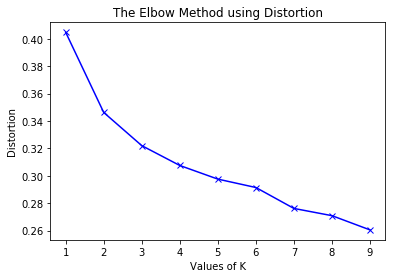

In [39]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

distortions = [] 
X=sd_grouped_clustering 
#X_normalized = MinMaxScaler().fit(X).transform(X)
X_normalized=sd_grouped_clustering

K = range(1,10) 
for k in K: 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(X_normalized) 
    dist=sum(np.min(cdist(X_normalized, kmeanModel.cluster_centers_, 'euclidean'),axis=1)) / X.shape[0]
    #print(dist)  
    distortions.append(dist)

plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()  


In [40]:
# set number of clusters to 8
kclusters = 8

sd_grouped_clustering = sd_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sd_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20] 

array([2, 0, 2, 6, 2, 0, 2, 3, 2, 3, 0, 0, 2, 2, 2, 2, 6, 0, 6, 2],
      dtype=int32)

In [41]:
sd_grouped_clustering.head()

,ATM,Accessories Store,Antique Shop,Arcade,Art Gallery,Astrologer,Auto Workshop,Automotive Shop,Bagel Shop,Bank,Bar,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Building,Business Service,Butcher,Camera Store,Candy Store,Casino,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Club House,College Cafeteria,Comedy Club,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cruise,Currency Exchange,Dance Studio,Department Store,Discount Store,Doctor's Office,Dog Run,Electronics Store,Entertainment Service,Event Service,Event Space,Eye Doctor,Fast Food,Flower Shop,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gun Range,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hostel,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indoor Play Area,Insurance Office,Intersection,Island,Jewelry Store,Kids Store,Laundromat,Laundry Service,Leather Goods Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Men's Store,Military Base,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Optical Shop,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,ParkRec,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Plaza,Pop-Up Shop,Pub,Public Bathroom,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon,Sculpture Garden,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Speakeasy,Sport,Sporting Goods Shop,Stables,Storage Facility,Supplement Shop,Tattoo Parlor,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Transit,Vape Store,Video Game Store,Video Store,Wine Shop,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.062500,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.312500,0.125,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.062500,0.0,0.0,0.0,0.0,0.0,0.0625,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.062500,0.062500,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.187500,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0625,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.027027,0.0,0.0,0.0,0.000000,0

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [42]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()
sd_merged = sd_df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
#sd_merged = sd_merged.join(neighborhoods_venues_sorted.set_index('Neighborhoods'), on='Neighborhoods')
sd_merged=pd.merge(sd_merged, neighborhoods_venues_sorted, how='inner',left_on='Neighborhoods', right_on='Neighborhoods')
sd_merged.head() # check the last columns!

,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Ocean View Hills,32.568696,-117.014101,0,Intersection,ParkRec,Sport,Restaurant,Dog Run,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service
1,North Park,32.745260,-117.132350,2,Fast Food,Restaurant,Bar,Brewery,Yoga Studio,Bookstore,Laundromat,Liquor Store,Lounge,Gastropub
2,La Playa,32.718300,-117.233700,2,Restaurant,Fast Food,ParkRec,Bar,Theater,Nightclub,Flower Shop,Sport,Bookstore,Health & Beauty Service
3,Little Italy,32.725860,-117.167600,2,Restaurant,Fast Food,Bar,Hotel,Market,Ice Cream Shop,ATM,Rental Car Location,Pub,Pilates Studio
4,Serra Mesa,32.795980,-117.124940,0,Intersection,Fast Food,Home Service,Liquor Store,Dog Run,Flower Shop,Eye Doctor,Event Space,Event Service,Entertainment Service


Let's visualize the resulting clusters

In [43]:
# create map
map_clusters = folium.Map(location=[sd_latitude, sd_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sd_merged['Latitude'], sd_merged['Longitude'], sd_merged['Neighborhoods'], sd_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>
## 5. Examine Clusters

Now, we can examine each cluster and determine the discriminating venue categories that distinguish each cluster.

In [126]:
#define a function to display the cluster
def show_cluster(num=0):
    return sd_merged.loc[sd_merged['Cluster Labels'] == num, sd_merged.columns[[0] + list(range(4, sd_merged.shape[1]))]]

#### Cluster 1: Park, Store, Food, Pet and Others

In [125]:
show_cluster(0)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alta Vista,Pet Store,Child Care Service,Liquor Store,Yoga Studio,Dog Run,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service
6,Serra Mesa,Intersection,Fast Food,Home Service,Liquor Store,Dog Run,Flower Shop,Eye Doctor,Event Space,Event Service,Entertainment Service
11,La Jolla Village,Furniture / Home Store,Pet Store,Bank,Restaurant,Martial Arts Dojo,Market,Fast Food,Shoe Store,Shopping Mall,Mobile Phone Shop
14,Bay Ho,ParkRec,Health & Beauty Service,Restaurant,Fast Food,Credit Union,Cruise,Currency Exchange,Dance Studio,Department Store,Discount Store
23,Broadway Heights,Ice Cream Shop,Business Service,Yoga Studio,Electronics Store,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service
28,Shelter Island,ParkRec,Restaurant,Hotel,Music Venue,Sport,Bar,Resort,Boat or Ferry,Hotel Pool,Island
29,Otay Mesa West,Liquor Store,Fast Food,Sport,Recreation Center,Doctor's Office,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
34,San Ysidro,Clothing Store,Restaurant,Fast Food,Shoe Store,Cosmetics Shop,Mobile Phone Shop,Sporting Goods Shop,Convenience Store,Outlet Mall,Chocolate Shop
36,Ocean View Hills,Intersection,ParkRec,Sport,Restaurant,Dog Run,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service
37,Old Town,Restaurant,Museum,Fast Food,Gift Shop,Transit,ParkRec,Hotel,Art Gallery,Market,Theater


#### Cluster 2: ParkRec and Yoga Studio

In [127]:
show_cluster(1)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
12,Paradise Hills,ParkRec,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
17,Tijuana River Valley,ParkRec,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
21,Rancho Encantada,ParkRec,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
49,Cortez Hill,ParkRec,Fast Food,Yoga Studio,Dog Run,Flower Shop,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
57,Del Mar Mesa,ParkRec,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
67,East Elliott,ParkRec,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
69,Lake Murray,ParkRec,Fast Food,Yoga Studio,Dog Run,Flower Shop,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
91,Encanto,ParkRec,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store


#### Cluster 3: Food, Park, Doctor and others

In [128]:
show_cluster(2)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Gateway,Convenience Store,Restaurant,Fast Food,Market,Football Stadium,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
5,Carmel Valley,Restaurant,Fast Food,ParkRec,Bank,Gas Station,Dance Studio,Clothing Store,Rental Car Location,Mobile Phone Shop,Shopping Mall
9,Mission Beach,Fast Food,ParkRec,Restaurant,Boat or Ferry,Bar,Board Shop,Pedestrian Plaza,Resort,Smoke Shop,Clothing Store
15,Otay Mesa,Fast Food,Convenience Store,Restaurant,Gas Station,Intersection,Hotel,Doctor's Office,Event Space,Event Service,Entertainment Service
18,Memorial,Restaurant,Fast Food,ParkRec,Convenience Store,Vape Store,Laundromat,Automotive Shop,Laundry Service,Dog Run,Eye Doctor
19,Egger Highlands,Restaurant,Fast Food,Liquor Store,Pharmacy,Motel,Auto Workshop,Automotive Shop,Thrift / Vintage Store,Discount Store,Tattoo Parlor
20,Pacific Highlands Ranch,Restaurant,Fast Food,Pharmacy,Ice Cream Shop,Furniture / Home Store,Market,Sport,Sporting Goods Shop,Gastropub,Yoga Studio
24,Point Loma Heights,Fast Food,Restaurant,Yoga Studio,Construction & Landscaping,Flower Shop,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
25,Kensington,Fast Food,Restaurant,Theater,Rock Club,Sculpture Garden,Shipping Store,Liquor Store,Bank,Market,ParkRec
26,North Park,Fast Food,Restaurant,Bar,Brewery,Yoga Studio,Bookstore,Laundromat,Liquor Store,Lounge,Gastropub


#### Cluster 4: Sport

In [129]:
show_cluster(3)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,Black Mountain Ranch,Sport,Yoga Studio,Fountain,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
65,Bay Terraces,Sport,Transit,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service


#### Cluster 5: IT Services

In [130]:
show_cluster(4)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
88,Tierrasanta,IT Services,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store


#### Cluster 6: Stables

In [131]:
show_cluster(5)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
103,Torrey Hills,Stables,Yoga Studio,Fountain,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store


#### Cluster 7: Food Yoga and Landscaping

In [132]:
show_cluster(6)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kearny Mesa,Restaurant,Fast Food,Rental Car Location,Market,Yoga Studio,Construction & Landscaping,Clothing Store,Plaza,Discount Store,Business Service
3,Shelltown,Restaurant,Fast Food,Market,Ice Cream Shop,Leather Goods Store,Liquor Store,Bubble Tea Shop,Bar,Pub,Motel
4,El Cerrito,Bar,Restaurant,Marijuana Dispensary,Yoga Studio,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service
7,City Heights,Restaurant,Fast Food,Discount Store,Pet Store,Sport,Liquor Store,Bar,Home Service,Dance Studio,Department Store
8,Hillcrest,Restaurant,Fast Food,Bar,Market,Photography Studio,Doctor's Office,Cheese Shop,Mobile Phone Shop,Massage Studio,Gastropub
10,Sherman Heights,Restaurant,Liquor Store,Yoga Studio,Discount Store,Convenience Store,Museum,Fast Food,Bar,ParkRec,Hotel
13,North City,Restaurant,Fast Food,Bank,Bagel Shop,Mobile Phone Shop,Shopping Mall,Music Venue,Theater,Ice Cream Shop,Other Repair Shop
16,Mt. Hope,Restaurant,Liquor Store,ParkRec,Shipping Store,Doctor's Office,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
22,Scripps Miramar Ranch,Restaurant,Yoga Studio,Construction & Landscaping,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store
27,Midtown,Restaurant,Fast Food,Bar,Hotel,Theater,Plaza,Gastropub,Lingerie Store,Chocolate Shop,Mobile Phone Shop


#### Cluster 8: Recording Studio

In [133]:
show_cluster(7)

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
93,Emerald Hills,Recording Studio,Yoga Studio,Dog Run,Flower Shop,Fast Food,Eye Doctor,Event Space,Event Service,Entertainment Service,Electronics Store


<a id='item6'></a>
## 6. Recommendation

Every one has different preferences when considering these many categories. Let's consider one case when John really likes ParkRec and Theater, then Fast Food and Public Transit, and he does not like Gas Station. He does not care about others.

In [44]:
profile={"Fast Food":5.0, "ParkRec": 10.0, "Theater":10.0, "Transit": 5.0, "Gas Station": 0.2}

In [45]:
sd_grouped_total = sd_onehot.groupby('Neighborhoods').sum().reset_index()
sd_grouped_total.head()

,Neighborhoods,ATM,Accessories Store,Antique Shop,Arcade,Art Gallery,Astrologer,Auto Workshop,Automotive Shop,Bagel Shop,Bank,Bar,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Building,Business Service,Butcher,Camera Store,Candy Store,Casino,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Club House,College Cafeteria,Comedy Club,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cruise,Currency Exchange,Dance Studio,Department Store,Discount Store,Doctor's Office,Dog Run,Electronics Store,Entertainment Service,Event Service,Event Space,Eye Doctor,Fast Food,Flower Shop,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gun Range,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hostel,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indoor Play Area,Insurance Office,Intersection,Island,Jewelry Store,Kids Store,Laundromat,Laundry Service,Leather Goods Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Men's Store,Military Base,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Optical Shop,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,ParkRec,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Plaza,Pop-Up Shop,Pub,Public Bathroom,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon,Sculpture Garden,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Speakeasy,Sport,Sporting Goods Shop,Stables,Storage Facility,Supplement Shop,Tattoo Parlor,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Transit,Vape Store,Video Game Store,Video Store,Wine Shop,Women's Store,Yoga Studio
0,Allied Gardens,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,5,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,Alta Vista,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Balboa Park,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10,0,0,1,0,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,0,1,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,2,0,0,0,0,0,0
3,Bankers Hill,0,0,0,0,0,0,0,0,0,1,3,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,5,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Barrio Logan,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,9,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [46]:
#generate user profile for all categories
cat=sd_grouped_total.columns[1:].to_list()
p=np.empty([1,len(cat)])
p.fill(1.0)
profile_all=pd.DataFrame(p,columns=cat)
for key, val in profile.items():
    profile_all[key]=val
#profile_all

In [47]:
#Compute the final score based on user profile and neighborhood venue table
score=(sd_grouped_total.iloc[:,1:]*profile_all.iloc[0,]).sum(axis=1)/(profile_all.iloc[0,].sum())
sd_grouped_total.insert(1, "Score", score)
Top_Profile=sd_grouped_total.sort_values(by=["Score"], ascending=False)[0:5]

In [218]:
Top_Profile.head()

,Neighborhoods,Score,ATM,Accessories Store,Antique Shop,Arcade,Art Gallery,Astrologer,Auto Workshop,Automotive Shop,Bagel Shop,Bank,Bar,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Building,Business Service,Butcher,Camera Store,Candy Store,Casino,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Club House,College Cafeteria,Comedy Club,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cruise,Currency Exchange,Dance Studio,Department Store,Discount Store,Doctor's Office,Dog Run,Electronics Store,Entertainment Service,Event Service,Event Space,Eye Doctor,Fast Food,Flower Shop,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gun Range,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hostel,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indoor Play Area,Insurance Office,Intersection,Island,Jewelry Store,Kids Store,Laundromat,Laundry Service,Leather Goods Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Men's Store,Military Base,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Optical Shop,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,ParkRec,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Plaza,Pop-Up Shop,Pub,Public Bathroom,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon,Sculpture Garden,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Speakeasy,Sport,Sporting Goods Shop,Stables,Storage Facility,Supplement Shop,Tattoo Parlor,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Transit,Vape Store,Video Game Store,Video Store,Wine Shop,Women's Store,Yoga Studio
32,Gaslamp Quarter,1.097695,0,0,0,0,2,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,16,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
54,Midtown,1.097695,0,0,0,1,0,0,0,0,0,0,12,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,0,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0
48,Little Italy,0.944018,1,0,0,0,0,0,0,0,0,0,8,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,20,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,4,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,28,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
20,Columbia,0.916575,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
40,Horton Plaza,0.911087,0,3,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,8,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,1,1,0,0,0,0,0,0,0,17,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,1,1,2,0,0,0,0,0,1,1,0,0,0


In [219]:
# sort and get the top 5 neighborhoods
top=pd.merge(Top_Profile, sd_df, how='left',left_on='Neighborhoods', right_on='Neighborhoods')
top

,Neighborhoods,Score,ATM,Accessories Store,Antique Shop,Arcade,Art Gallery,Astrologer,Auto Workshop,Automotive Shop,Bagel Shop,Bank,Bar,Bed & Breakfast,Beer Store,Big Box Store,Bike Rental / Bike Share,Board Shop,Boat Rental,Boat or Ferry,Bookstore,Border Crossing,Boutique,Bowling Alley,Brewery,Bubble Tea Shop,Building,Business Service,Butcher,Camera Store,Candy Store,Casino,Cheese Shop,Child Care Service,Chocolate Shop,Clothing Store,Club House,College Cafeteria,Comedy Club,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Credit Union,Cruise,Currency Exchange,Dance Studio,Department Store,Discount Store,Doctor's Office,Dog Run,Electronics Store,Entertainment Service,Event Service,Event Space,Eye Doctor,Fast Food,Flower Shop,Football Stadium,Fountain,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gift Shop,Gun Range,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Hobby Shop,Home Service,Hostel,Hotel,Hotel Pool,IT Services,Ice Cream Shop,Indoor Play Area,Insurance Office,Intersection,Island,Jewelry Store,Kids Store,Laundromat,Laundry Service,Leather Goods Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Men's Store,Military Base,Miscellaneous Shop,Mobile Phone Shop,Motel,Motorcycle Shop,Moving Target,Museum,Music Store,Music Venue,Neighborhood,Nightclub,Nightlife Spot,Office,Optical Shop,Other Repair Shop,Outlet Mall,Outlet Store,Paper / Office Supplies Store,ParkRec,Pedestrian Plaza,Pet Store,Pharmacy,Photography Studio,Pilates Studio,Plaza,Pop-Up Shop,Pub,Public Bathroom,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Residential Building (Apartment / Condo),Resort,Restaurant,Rock Club,Salon,Sculpture Garden,Shipping Store,Shoe Repair,Shoe Store,Shopping Mall,Shopping Plaza,Smoke Shop,Spa,Speakeasy,Sport,Sporting Goods Shop,Stables,Storage Facility,Supplement Shop,Tattoo Parlor,Theater,Thrift / Vintage Store,Tour Provider,Toy / Game Store,Transit,Vape Store,Video Game Store,Video Store,Wine Shop,Women's Store,Yoga Studio,Latitude,Longitude
0,Gaslamp Quarter,1.097695,0,0,0,0,2,0,0,0,0,0,13,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,16,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,2,0,1,0,1,0,0,0,0,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0,0,0,0,0,1,0,1,3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,32.707840,-117.160110
1,Midtown,1.097695,0,0,0,1,0,0,0,0,0,0,12,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,2,0,1,0,0,0,0,0,0,0,34,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,4,0,0,0,0,0,0,0,0,0,0,32.715680,-117.161710
2,Little Italy,0.944018,1,0,0,0,0,0,0,0,0,0,8,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,20,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,1,4,0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,28,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,32.725860,-117.167600
3,Columbia,0.916575,0,0,0,0,0,0,0,0,0,0,7,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,17,0,0,0,1,0,0,0,2,1,0,0,0,0,0,0,0,1,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,33,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32.722298,-117.167409
4,Horton Plaza,0.911087,0,3,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0,0,2,0,2,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,8,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,2,1,1,0,0,0,0,0,0,0,17,0,0,0,0,0,3,0,0,0,0,0,2,0,0,0,1,1,2,0,0,0,0,0,1,1,0,0,0,32.715650,-117.165170


### Create a map of San Diego with top recommendations superimposed on top.

In [220]:
# create map of top recommendations using latitude and longitude values
map_top = folium.Map(location=[sd_latitude, sd_longitude], zoom_start=12)

# add markers to map
for lat, lng, neighborhood, ind in zip(top['Latitude'], top['Longitude'], top['Neighborhoods'], top.index):
    label = folium.Popup(str(ind+1)+': '+ neighborhood, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_top)  
map_top